
# Intelligent Acoustic-Based Vehicle Fault Diagnosis using YAMNet and LLMs

End-to-end pipeline to extract audio embeddings, train a multimodal classifier, log experiments, and generate user-friendly messages with an LLM.



## 1. Library setup and imports
Dependencies for audio handling (librosa, TF Hub), modeling with Keras/TensorFlow, sklearn metrics, and experiment tracking with W&B.


In [1]:
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import librosa
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback
from collections import Counter
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


2025-12-10 12:09:54.310841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 12:09:54.346245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 12:09:55.310544: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sfp/miniconda3/envs/uni/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: U


## 2. Experiment tracking with W&B
Wandb helps with the visualization of training graphs.

Authenticate and configure callbacks to log hyperparameters, metrics, and checkpoints during training.


In [2]:
wandb.login()  # Authenticate the current session


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose "Don't visualize my results"


False

In [3]:
exper = wandb.init(project="car_fault_detection",                  # Project name
                   name="yamnet_noise",                            # Experiment name
                   config={                                        # Configuration parameters
                        "epochs": 30,
                        "batch_size": 32,
                        "model": "YAMNet+MLP",
                        "context_embedding_dim": 4,
                        "dense_units": [256, 128]
    }
)

config = wandb.config

# Log validation metrics and keep the best checkpoint
wandb_callback = [WandbMetricsLogger(), WandbModelCheckpoint(filepath='model.keras', monitor='val_loss', save_best_only=True)]


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.



## 3. Dataset loading and quick exploration
Read the metadata file from Drive and take a quick look to validate audio, context, and label columns.


In [ ]:
DATA_PATH = "PATH/TO/DATASET/FILE"               # Path to the dataset

df = pd.read_csv(DATA_PATH + "metadata.csv")
df.head()


,file,label,context
0,serpentine_belt_idle_state_0000.wav,serpentine_belt,4.0
1,serpentine_belt_idle_state_0001.wav,serpentine_belt,4.0
2,serpentine_belt_idle_state_0002.wav,serpentine_belt,4.0
3,serpentine_belt_idle_state_0003.wav,serpentine_belt,4.0
4,serpentine_belt_idle_state_0004.wav,serpentine_belt,4.0


### 3.1 Data class info


In [6]:
df['label'].value_counts()  # Inspect label balance


label
car_clean                300
car_knocking             299
normal_engine_idle       264
power_steering           129
serpentine_belt          116
low_oil                  107
normal_brakes             77
worn_out_brakes           76
bad_ignition              62
normal_engine_startup     61
dead_battery              57
Name: count, dtype: int64


As seen on the table above, the classes are highly unbalanced. Later on the notebook, a data augmentation method will be applied in order to balance the classes.



## 4. YAMNet backbone for embeddings
Download and load the pretrained model from TensorFlow Hub to extract representations for each audio clip.


In [7]:
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")
print("YAMNet loaded")


2025-12-10 13:17:12.607625: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


YAMNet loaded



### 4.1 Audio utilities
Helpers to load audio at 16 kHz, get the mean YAMNet embedding, and return 1024-dimension vectors.


In [ ]:
def load_audio(path):
    """Load an audio file at 16 kHz, returning float32 samples."""
    y, sr = librosa.load(path, sr=16000)                                     # YAMNet expects 16kHz
    return y.astype(np.float32)


def get_embedding(path):
    """Run YAMNet on disk audio and return the average embedding."""
    waveform = load_audio(path)
    # YAMNet wants a tensor 1D float32
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

    scores, embeddings, spectrogram = yamnet(waveform)
    embedding = tf.reduce_mean(embeddings, axis=0)  # (1024,)
    return embedding.numpy()

def get_embedding_from_array(audio, sr):
    """Run YAMNet on an in-memory waveform."""
    waveform = audio.astype(np.float32)

    # YAMNet requires a 1D vector float32 with amplitude [-1,1]
    scores, embeddings, spectrogram = yamnet(waveform)

    return np.mean(embeddings.numpy(), axis=0)



### Data augmentation + noise
Due to the unbalanced classes, we duplicate data and add some noise in order to balance our dataset without using the same data.


In [ ]:
# ==============================================
# A. Data augmentation only for minority classes
# ==============================================

def add_noise_to_audio(audio, noise_factor=0.004):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Count instances per class to find minority groups
label_counts = Counter(df["label"])
max_count = max(label_counts.values())

audio_raw_list = []                                          # original audio samples
audio_aug_list = []                                          # augmented audio for minority labels
context_list = []
label_list = []

for _, row in df.iterrows():
    filepath = os.path.join(DATA_PATH, "audio", row["file"])
    audio, sr = librosa.load(filepath, sr=None)

    label = row["label"]
    context = int(row["context"])

    # Store original audio
    audio_raw_list.append(audio)
    context_list.append(context)
    label_list.append(label)

    # If the class is under-represented, generate noisy variants
    num_samples = label_counts[label]
    num_to_generate = max_count - num_samples

    if num_to_generate > 0:
        audio_noisy = add_noise_to_audio(audio, noise_factor=0.004)
        audio_aug_list.append((audio_noisy, context, label))



## 5. Embedding extraction and dataset assembly
Process all audios to generate embeddings, numeric context, and labels; consolidate everything into NumPy arrays ready for modeling.


In [10]:
# ==================================================
# B. Embeddings for originals + augmented minorities
# ==================================================

X_audio = []
X_context = []
y = []

# Embeddings for originals
for audio, context, label in zip(audio_raw_list, context_list, label_list):
    emb = get_embedding_from_array(audio, sr)
    X_audio.append(emb)
    X_context.append(context)
    y.append(label)

# Embeddings for augmented samples (minority classes)
for audio_noisy, context, label in audio_aug_list:
    emb_noisy = get_embedding_from_array(audio_noisy, sr)
    X_audio.append(emb_noisy)
    X_context.append(context)
    y.append(label)

X_audio = np.array(X_audio)
X_context = np.array(X_context)
y = np.array(y)

print("Shapes:")
print("X_audio:", X_audio.shape)
print("X_context:", X_context.shape)
print("y:", y.shape)


Shapes:
X_audio: (2796, 1024)
X_context: (2796,)
y: (2796,)



### 5.1 One-hot label encoding
Convert text labels to integers and one-hot vectors with `LabelEncoder`; `le.classes_` stores the ordered classes.


In [11]:
le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = to_categorical(y_int)

le.classes_


array(['bad_ignition', 'car_clean', 'car_knocking', 'dead_battery',
       'low_oil', 'normal_brakes', 'normal_engine_idle',
       'normal_engine_startup', 'power_steering', 'serpentine_belt',
       'worn_out_brakes'], dtype='<U21')


Note: the dataset contains 11 distinct vehicle-issue classes detected from audio.



## 6. Train/test split
Stratified 80/20 split for embeddings, context, and labels, preserving class proportions.


In [12]:
X_audio_train, X_audio_test, X_context_train, X_context_test, y_train, y_test = train_test_split(
    X_audio,
    X_context,
    y_cat,        # one-hot labels
    test_size=0.2,
    stratify=y_int,
    random_state=42
)


In [13]:
y_test_int = np.argmax(y_test, axis=1)



## 7. Multimodal model architecture
YAMNet embedding and context inputs, categorical embedding for context, fused dense layers, and softmax output; compiled with cross-entropy and accuracy.


In [14]:
# Inputs
inp_audio = layers.Input(shape=(1024,), name="audio_embedding")
inp_context = layers.Input(shape=(1,), dtype="int32", name="context_id")

# Context embedding
ctx_emb = layers.Embedding(input_dim=5, output_dim=4, name="context_embedding")(inp_context)
ctx_emb = layers.Flatten()(ctx_emb)

# Combine audio + context
x = layers.Concatenate()([inp_audio, ctx_emb])

# Dense layers
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)

# Output layer
out = layers.Dense(len(le.classes_), activation="softmax", name="output")(x)

# Build model
model = Model(inputs=[inp_audio, inp_context], outputs=out)

# Compile
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ context_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_embedding   │ (None, 1, 4)      │         20 │ context_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_embedding     │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4)         │          0 │ context_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1028)      │          0 │ audio_embedding[… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    131,712 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 11)        │        715 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 140,703 (549.62 KB)

 Trainable params: 140,703 (549.62 KB)

 Non-trainable params: 0 (0.00 B)


### 7.1 Training and logging
Train with validation, W&B callbacks, and the configured class weights.


In [15]:
history = model.fit(
    [X_audio_train, X_context_train],
    y_train,
    validation_split=0.2,
    batch_size=config.batch_size,
    callbacks=wandb_callback,
    epochs=config.epochs
)


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3182 - loss: 2.0745 - val_accuracy: 0.5424 - val_loss: 1.6197
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6091 - loss: 1.3381 - val_accuracy: 0.6853 - val_loss: 1.0044
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7287 - loss: 0.8739 - val_accuracy: 0.7344 - val_loss: 0.7125
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7847 - loss: 0.6735 - val_accuracy: 0.7991 - val_loss: 0.5623
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8199 - loss: 0.5515 - val_accuracy: 0.8259 - val_loss: 0.4894
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8356 - loss: 0.4774 - val_accuracy: 0.8080 - val_loss: 0.4606
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8535 - loss: 0.4216 - val_accuracy: 0.8594 - val_loss: 0.3901
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3967 - val_accuracy: 0.8683 - val_loss:

In [16]:
exper.finish()  # Close the W&B run


epoch/accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇███████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▆▇▇█▇▇▇▇▇▇██▇▇█▇██▇██████
epoch/val_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.95917
epoch/epoch,29
epoch/learning_rate,0.001
epoch/loss,0.1308
epoch/val_accuracy,0.89732



## 8. Model evaluation
Test predictions, loss/accuracy, confusion matrix, and classification report to assess per-class performance.


In [17]:
y_pred_probs = model.predict([X_audio_test, X_context_test])
y_pred_int = np.argmax(y_pred_probs, axis=1)

df_compare = pd.DataFrame({
    "true_label": [le.classes_[i] for i in y_test_int],
    "pred_label": [le.classes_[i] for i in y_pred_int],
    "correct": (y_test_int == y_pred_int),
    "pred_confidence": np.max(y_pred_probs, axis=1)
})

df_compare


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,true_label,pred_label,correct,pred_confidence
0,car_knocking,car_knocking,True,0.990187
1,car_clean,car_clean,True,0.992676
2,car_knocking,car_knocking,True,1.000000
3,worn_out_brakes,worn_out_brakes,True,0.999975
4,power_steering,power_steering,True,0.982163
...,...,...,...,...
555,car_knocking,car_clean,False,0.886543
556,car_clean,car_clean,True,0.977739
557,low_oil,low_oil,True,0.832326
558,normal_engine_startup,normal_engine_startup,True,0.910840


In [18]:
test_loss, test_acc = model.evaluate(
    [X_audio_test, X_context_test],
    y_test,
    verbose=1
)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9125 - loss: 0.2778 
Test Accuracy: 0.9125000238418579
Test Loss: 0.2778450846672058


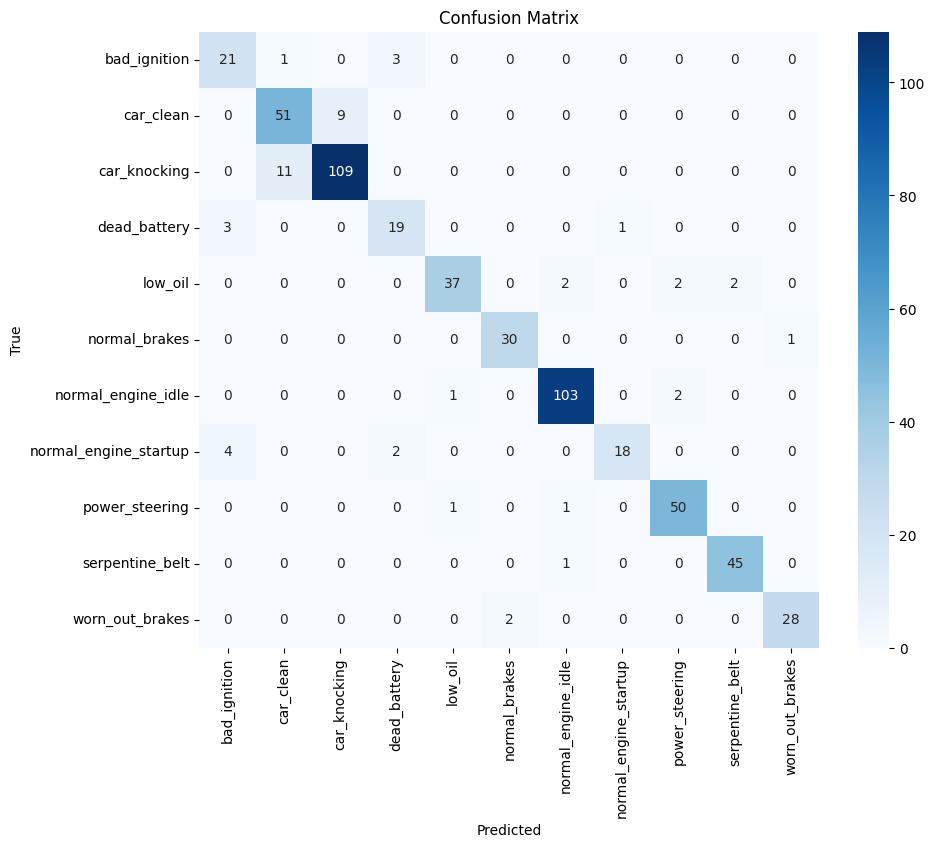

In [19]:
cm = confusion_matrix(y_test_int, y_pred_int)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


The confusion matrix clearly shows which test samples were correctly classified and which were incorrectly classified.

In [20]:
print(classification_report(y_test_int, y_pred_int, target_names=le.classes_))


                       precision    recall  f1-score   support

         bad_ignition       0.75      0.84      0.79        25
            car_clean       0.81      0.85      0.83        60
         car_knocking       0.92      0.91      0.92       120
         dead_battery       0.79      0.83      0.81        23
              low_oil       0.95      0.86      0.90        43
        normal_brakes       0.94      0.97      0.95        31
   normal_engine_idle       0.96      0.97      0.97       106
normal_engine_startup       0.95      0.75      0.84        24
       power_steering       0.93      0.96      0.94        52
      serpentine_belt       0.96      0.98      0.97        46
      worn_out_brakes       0.97      0.93      0.95        30

             accuracy                           0.91       560
            macro avg       0.90      0.90      0.90       560
         weighted avg       0.91      0.91      0.91       560



The model achieves an overall accuracy of 91%, demonstrating strong performance across most classes. Precision, recall, and F1-scores are consistently high, particularly for classes such as serpentine_belt, normal_engine_idle, and normal_brakes, which reach values above 0.95. Some classes with fewer samples, like car_clean and normal_engine_startup, show slightly lower recall, indicating occasional misclassifications. The macro and weighted averages confirm that the model performs robustly and maintains balanced effectiveness across the dataset, even with varying class sizes.


## 9. Inference and top-3 helper
Utility to fetch the three most probable classes and confidences for a test example.


In [21]:
def predict_top3_from_test(i):
    # Embedding shape must be (1, 1024)
    emb = np.array(X_audio_test[i]).reshape(1, 1024)

    # Context must be shape (1,1)
    ctx_val = int(X_context_test[i])            # ensure it is an integer
    ctx = np.array([[ctx_val]], dtype=np.int32) # correct shape for embedding

    # Predict
    probs = model.predict([emb, ctx], verbose=0)[0]

    # Top 3 indices
    top3_idx = probs.argsort()[-3:][::-1]

    return [(le.classes_[j], float(probs[j])) for j in top3_idx]


predict_top3_from_test(150)


[(np.str_('car_knocking'), 0.9531390070915222),
 (np.str_('car_clean'), 0.046820543706417084),
 (np.str_('normal_brakes'), 2.2211617761058733e-05)]


### Saving model + label encoder + data for LLM use

Persist the trained assets so the LLM notebook can load them for friendly explanations.


In [ ]:
path = 'PATH'                             # Define path to save model and encoder

In [ ]:
model.save('yamnet_model.keras')          # Save the trained model in defined path


In [23]:
import joblib
joblib.dump(le, 'label_encoder.plk')      # Save label encoder in defined path
 

['label_encoder.plk']

In [25]:
# Save test sets in defined path
np.save('X_audio_test.npy', X_audio_test)       
np.save('X_context_test.npy', X_context_test)
